In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

# 4.1 - Principal Component Analysis

In [ ]:
import cv2 as cv
from math import atan2, cos, sin, sqrt, pi
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
def convert_from_cv2_to_image(img: np.ndarray) -> Image:
    # return Image.fromarray(img)
    return Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2RGB))


def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    # return np.asarray(img)
    return cv.cvtColor(np.array(img), cv.COLOR_RGB2BGR)
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)
 
  ## [visualization1]
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
  ## [visualization1]
 
def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
 
  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
 
  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]
 
  ## [visualization]
  # Draw the principal components
  cv.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]
 
  # Label with the rotation angle
  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
  print(label)
  textbox = cv.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
  cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)
 
  return str(-int(np.rad2deg(angle)) - 90)
 
# Load the image
img = cv.imread("KIMIA-99/tool12.png")
input_img = img
# Was the image there?
if img is None:
  print("Error: File not found")
  exit(0)
 
# cv.imshow('Input Image', img)
 
# Convert image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
# Convert image to binary
_, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
 
# Find all the contours in the thresholded image
contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
curr = 0
ans = 0
for i, c in enumerate(contours):
 
  # Calculate the area of each contour
  area = cv.contourArea(c)
 
  # Ignore contours that are too small or too large
  if 10000 < area:
    continue
      
  # Draw each contour only for visualisation purposes
  cv.drawContours(img, contours, i, (0, 0, 255), 2)
 
  # Find the orientation of each shape
  k = getOrientation(c, img)
  print(area)
  if area > curr:
      curr = area
      ans = k
      
print('Answer')
print(ans)

folder_path = "KIMIA-99"

# Create a directory to save the processed images if it doesn't exist
output_folder = "output_images"
inv_output_folder = "inv_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Initialize a list to store the processed images
processed_images = []

# Iterate through all PNG files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        file_path = os.path.join(folder_path, filename)
        
        img = cv.imread(file_path)

        # Was the image there?
        if img is None:
            print(f"Error: File not found - {filename}")
            continue

        # cv.imshow('Input Image', img)

        # Convert image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Convert image to binary
        _, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

        # Find all the contours in the thresholded image
        contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        curr = 0
        ans1 = 0
        for i, c in enumerate(contours):

            # Calculate the area of each contour
            area = cv.contourArea(c)

            # Ignore contours that are too small or too large
            if 10000 < area:
                continue

            # Draw each contour only for visualization purposes
            cv.drawContours(img, contours, i, (0, 0, 255), 2)

            # Find the orientation of each shape
            k = getOrientation(c, img)
            print(f"Area for {filename}: {area}")
            if area > curr:
                curr = area
                ans1 = k
        angle = int(ans) - int(ans1)
        original_image = Image.open(file_path)
        rot = original_image.rotate(angle)
        output_file_path = os.path.join(output_folder, filename)
        rot.save(output_file_path)
        processed_images.append((filename, output_file_path))

# Close OpenCV windows after processing
cv.destroyAllWindows()

# Display all processed images with labels
for filename, img_path in processed_images:
    img = Image.open(img_path)
    plt.figure()
    plt.title(filename)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# 4.2 - Hierarchial Clustering 

# 4.3 - Guassian Mixture Models

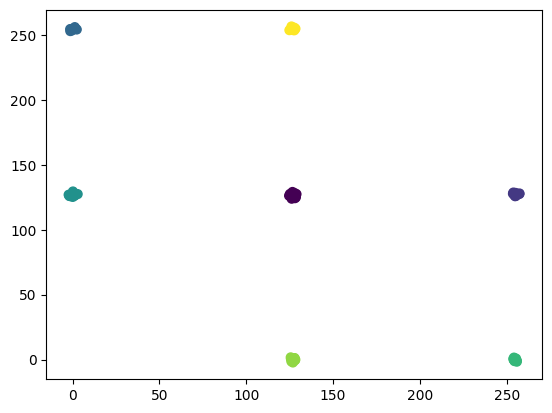

In [3]:

from sklearn.mixture import GaussianMixture
with open('colors.pkl', 'rb') as f:
    data = np.array(pickle.load(f))

X = data
gm = GaussianMixture(n_components=7, random_state=0).fit(X)
labels = gm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

/tmp/ipykernel_56408/874171567.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(new_dataset[:, 0], new_dataset[:, 1], s=40, cmap='viridis')


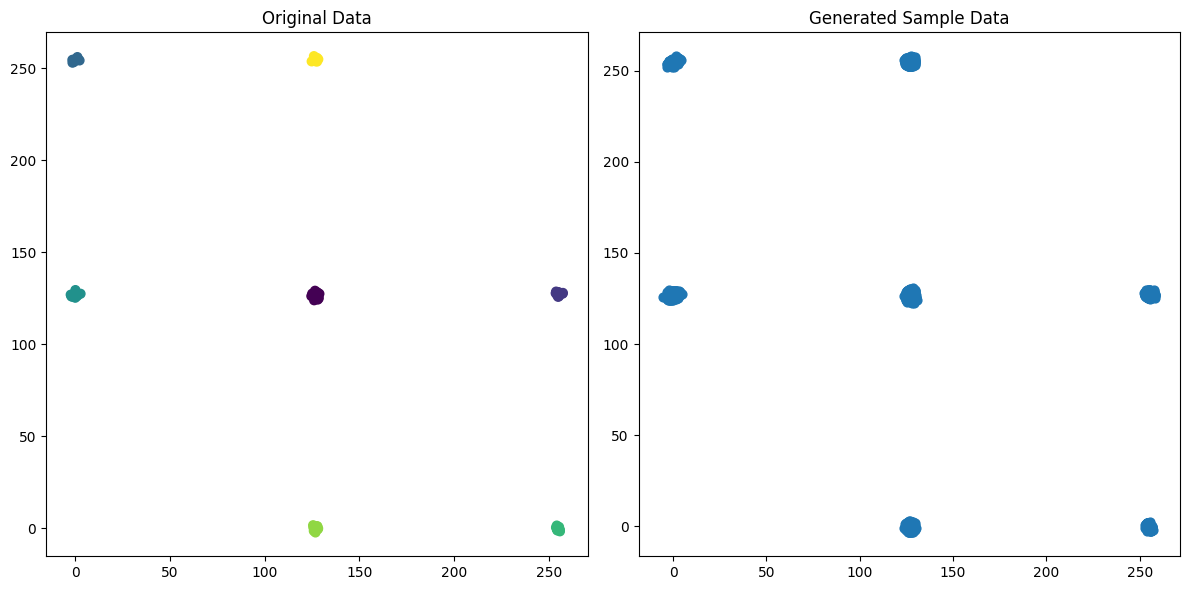

In [11]:
def generate_dataset(number_of_components,means,covariances,num_samples=1000):
    new_dataset = []
    for component in range(number_of_components):
        new_dataset.append(np.random.multivariate_normal(means[component],covariances[component],num_samples))
    return np.vstack(new_dataset)

new_dataset = generate_dataset(7,gm.means_,gm.covariances_)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.scatter(new_dataset[:, 0], new_dataset[:, 1], s=40, cmap='viridis')
plt.title('Generated Sample Data')

plt.tight_layout()
plt.show()